# Playing with Agents - Tic Tac Toe

### First install all relevant packages

In [1]:
#%pip install --upgrade huggingface_hub transformers[agents] duckduckgo-search h5py seaborn

### Then import the needed libraries

In [2]:
from transformers.agents import HfApiEngine, ReactJsonAgent, ReactCodeAgent, DuckDuckGoSearchTool, ManagedAgent

In [3]:
from huggingface_hub import login, InferenceClient 

In [4]:
import torch, json, os, re, time, random
import numpy as np
import pickle

In [5]:
from IPython.display import display, clear_output

In [6]:
import math, h5py

import scipy
from PIL import Image
from scipy import ndimage

import pandas as pd
import os

#visuals
import matplotlib.pyplot as plt
%matplotlib inline

### Login to Huggingface to use their architecture

In [7]:
hf_token = ""
login(hf_token,add_to_git_credential=False) 

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /home/moebius/.cache/huggingface/token
Login successful


### Now define the repositity you want to use

I wanted to experiment with Qwen

In [8]:
repo_id = "Qwen/Qwen2.5-72B-Instruct"

### Select the right remote engine 

In [9]:
llm_engine = HfApiEngine(model=repo_id)  

### And setup the game

A standard TicTacToe board has three rows and three columns

In [10]:
BOARD_ROWS=3
BOARD_COLS=3

In [11]:
class Board:
    
    def __init__(self, p1, p2):

        self.board = np.zeros((BOARD_ROWS,BOARD_COLS))
        self.p1 = p1
        self.p2 = p2
        self.isEnd = False
        self.boardHash = None
        self.scoreboard={'p1':0,'p2':0}
        #self.fig, self.ax = plt.subplots(figsize=(6, 6))
        
        # init p1 plays first
        self.playerSymbol = 1
        self.statistics=[]
    
    # get unique hash of current board state
    def getHash(self):
        self.boardHash = str(self.board.reshape(BOARD_COLS * BOARD_ROWS))
        return self.boardHash

    #return which positions are avaiable
    def availablePositions(self):
        positions = []
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                if self.board[i, j] == 0:
                    positions.append((i, j))  # need to be tuple
        return positions

    #set the board position
    def updateState(self, position):
        self.board[position] = self.playerSymbol
        # switch to another player
        self.playerSymbol = -1 if self.playerSymbol == 1 else 1

    # Provide reinforcement learning rewards only when game ends
    def giveReward(self):
        result = self.winner()
        # backpropagate reward
        if result == 1:
            print(f"{self.p1.name} wins")
            #self.showBoard()
            self.p1.feedReward(1)
            self.p2.feedReward(0)
            tmpScore=int(self.scoreboard['p1'])
            self.scoreboard.update({'p1':tmpScore+1})
        elif result == -1:
            print(f"{self.p2.name} wins")
            #self.showBoard()
            self.p1.feedReward(0)
            self.p2.feedReward(1)
            tmpScore=int(self.scoreboard['p2'])
            self.scoreboard.update({'p2':tmpScore+1})
        else:
            print("Draw")
            #self.showBoard()
            self.p1.feedReward(0.5)
            self.p2.feedReward(0.5)

    def winner(self):
        
        # row
        for i in range(BOARD_ROWS):
            if sum(self.board[i, :]) == 3:
                self.isEnd = True
                return 1
            if sum(self.board[i, :]) == -3:
                self.isEnd = True
                return -1
        # col
        for i in range(BOARD_COLS):
            if sum(self.board[:, i]) == 3:
                self.isEnd = True
                return 1
            if sum(self.board[:, i]) == -3:
                self.isEnd = True
                return -1
            
        # diagonal
        diag_sum1 = sum([self.board[i, i] for i in range(BOARD_COLS)])
        diag_sum2 = sum([self.board[i, BOARD_COLS - i - 1] for i in range(BOARD_COLS)])
        diag_sum = max(abs(diag_sum1), abs(diag_sum2))
        if diag_sum == 3:
            self.isEnd = True
            if diag_sum1 == 3 or diag_sum2 == 3:
                return 1
            else:
                return -1

        # tie
        # no available positions
        if len(self.availablePositions()) == 0:
            self.isEnd = True
            return 0
        # not end
        self.isEnd = False
        return None
    
    def play(self, rounds=100):
       
        for i in range(rounds):

            clear_output(wait=True)
            print("Rounds {}/{}".format(i, rounds))
            if i % 1000 == 0:
                print(game.scoreboard)
                time.sleep(1)

            self.p1.game_state=[]
            self.p2.game_state=[]
            
            while not self.isEnd:

                # Player 1
                positions = self.availablePositions()
                p1_action = self.p1.chooseAction(positions, self.board, self.playerSymbol)

                #print(f" P1 : {p1_action} ")
                
                # take action and upate board state
                self.updateState(p1_action)
                board_hash = self.getHash()
                self.p1.addState(board_hash)

                self.showBoard()
                # check board status if it is end
                win = self.winner()
                if win is not None:
                    # self.showBoard()
                    # ended with p1 either win or draw
                    self.giveReward()
                    self.p1.reset()
                    self.p2.reset()
                    self.reset()
                    break

                else:
                    # Player 2
                    positions = self.availablePositions()
                    p2_action = self.p2.chooseAction(positions, self.board, self.playerSymbol)

                    self.updateState(p2_action)
                    board_hash = self.getHash()
                    self.p2.addState(board_hash)
                    #self.showBoard()
                    win = self.winner()
                    if win is not None:
                        # self.showBoard()
                        # ended with p2 either win or draw
                        self.giveReward()
                        self.p1.reset()
                        self.p2.reset()
                        self.reset()
                        break

            # Now game is finished
            
            self.showBoard()
            self.statistics.append({i:{
                                    'p1' : self.p1.game_state,
                                    'p2' : self.p2.game_state,
                                    }})        

    #Monitor progrss
    def printBoard(self):
        # p1: x  p2: o
        for i in range(0, BOARD_ROWS):
            print('-------------')
            out = '| '
            for j in range(0, BOARD_COLS):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('-------------')

    def showBoard(self):
        # Clear the previous output
        clear_output(wait=True)

        # Create a new figure each time
        plt.figure(figsize=(6, 6))
        
        plt.title("Tic-Tac-Toe Board")
        plt.xlim(0, 3)
        plt.ylim(0, 3)
        plt.xticks([])
        plt.yticks([])

        # Draw grid
        for i in range(1, 3):
            plt.axhline(y=i, color='k', linestyle='-')
            plt.axvline(x=i, color='k', linestyle='-')

        # Place X and O
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                if self.board[i, j] == 1:
                    plt.text(j + 0.5, 2 - i + 0.5, 'X', fontsize=40, ha='center', va='center')
                elif self.board[i, j] == -1:
                    plt.text(j + 0.5, 2 - i + 0.5, 'O', fontsize=40, ha='center', va='center')

        # Display the plot
        display(plt.gcf())
        plt.close()  # Close the figure to free up memory

    # board reset
    def reset(self):
        self.board = np.zeros((BOARD_ROWS, BOARD_COLS))
        self.boardHash = None
        self.isEnd = False
        self.playerSymbol = 1



### Initialize the different player types


In [12]:
class Player:

    def __init__(self, name, exp_rate=0.3):
        #import numpy as np
        #import pickle

        self.name = name
        self.states = []  # record all positions taken
        self.lr = 0.2
        self.exp_rate = exp_rate
        self.decay_gamma = 0.9
        self.states_value=self.loadPolicy('policy_' + str(self.name))
            
        if self.states_value is None:
            self.states_value = {}  # state -> value
        self.game_state=[]

    def getHash(self, board):
        boardHash = str(board.reshape(BOARD_COLS * BOARD_ROWS))
        return boardHash

    def chooseAction(self, positions, current_board, symbol):
        
        if np.random.uniform(0, 1) <= self.exp_rate:

            #print(f"Player {self.name} is taking a random action")
            # take random action
            idx = np.random.choice(len(positions))
            action = positions[idx]
            value=0
            decision_type="random"
            next_boardHash=None
        else:

            #print(f"Player {self.name} is taking a deterministic action")
            decision_type="deterministic"
            value_max = int(-Inf)
            for p in positions:
                next_board = current_board.copy()
                next_board[p] = symbol
                next_boardHash = self.getHash(next_board)
                value = 0 if self.states_value.get(next_boardHash) is None else self.states_value.get(next_boardHash)
                
                if value >= value_max:
                    value_max = value
                    action = p


           
            #time.sleep(random.uniform(0.1, 2.999))
        #print("{} takes action {}".format(self.name, action))

        self.game_state.append(
                {
                'positions':positions,
                'current_board':current_board,
                'symbol':symbol,
                'player' : self.name,
                'decision_type':decision_type,
                'boardHash':next_boardHash,
                'move' : { 'action':action, 'value':value, 'no':len(self.game_state)+1}
                }
            )
            
        return action

    # append a hash state
    def addState(self, state):
        self.states.append(state)

    # at the end of game, backpropagate and update states value
    def feedReward(self, reward):
        for st in reversed(self.states):
            if self.states_value.get(st) is None:
                self.states_value[st] = 0
            self.states_value[st] += self.lr * (self.decay_gamma * reward - self.states_value[st])
            reward = self.states_value[st]

    def reset(self):
        self.states = []

    def savePolicy(self):
        #print(self.states_value)
        fw = open('policy_' + str(self.name), 'wb')
        pickle.dump(self.states_value, fw)
        fw.close()

    def loadPolicy(self, file):
        fr = open(file, 'rb')
        self.states_value = pickle.load(fr)
        fr.close()

In [13]:
class RandomPlayer(Player):

    def __init__(self, name, exp_rate=0.3):
        # Call the parent class's constructor
        super().__init__(name)
        self.name = name
        self.exp_rate = exp_rate

    def chooseAction(self, positions, current_board, symbol):
        
        action=random.choice(positions)

        next_board = current_board.copy()
        next_board[action] = symbol  # Add symbol to a possible position
        next_boardHash = self.getHash(next_board)

        decision_type="random"
        
        self.game_state.append(
            {
            'positions':positions,
            'current_board':current_board,
            'symbol':symbol,
            'player' : self.name,
             'boardHash':next_boardHash,
            'move' : { 'action':action, 'decision_type': decision_type, 'value':0, 'no':len(self.game_state)+1}
            }
        )
        
        #time.sleep(random.uniform(0.1, 0.999))
        #print("{} takes action {}".format(self.name, action))
       
        return action #action is a tuple like this : (2, 2)   

In [14]:
class RLPlayer(Player):

    def __init__(self, name, exp_rate=0.3):
        # Call the parent class's constructor
        super().__init__(name)
        self.name = name
        self.exp_rate = exp_rate

    def isWinningMove(self, board, symbol):
        # Check rows
        for row in board:
            if all([s == symbol for s in row]):
                return True
    
        # Check columns
        for col in range(len(board)):
            if all([board[row][col] == symbol for row in range(len(board))]):
                return True
    
        # Check diagonals
        if all([board[i][i] == symbol for i in range(len(board))]):  # Top-left to bottom-right diagonal
            return True
    
        if all([board[i][len(board) - i - 1] == symbol for i in range(len(board))]):  # Top-right to bottom-left diagonal
            return True
    
        return False


    def chooseAction(self, positions, current_board, symbol):
        
        opponent_symbol = -1 if symbol == 1 else 1
        action = None
        decision_type = 'normal'
        value=0
        
        # Step 1: Check for a winning move
        for p in positions:
            next_board = current_board.copy()
            next_board[p] = symbol  # Place own symbol
            if self.isWinningMove(next_board, symbol):  # If this move results in a win
                action = p
                decision_type = 'win'
                break
    
        # Step 2: If no winning move, check for a blocking move
        if action is None:
            for p in positions:
                next_board = current_board.copy()
                next_board[p] = opponent_symbol  # Simulate opponent's move
                if self.isWinningMove(next_board, opponent_symbol):  # If opponent can win
                    action = p
                    decision_type = 'block'
                    break
    
        # Step 3: If neither winning nor blocking, proceed with normal value-based decision
        #print(f" stage {self.game_state}, len {len(self.game_state)},  Symbol : {symbol}")
        
        if len(self.game_state)==0 and symbol==1:
            #if this is the first move, then select a choice by random.
            action=random.choice(positions)
            #print(f" action {action}")
        else:
            
            if action is None:
                value_max = float('-inf')
                for p in positions:  # Loop over all possible positions
                    next_board = current_board.copy()
                    next_board[p] = symbol  # Add symbol to a possible position
                    next_boardHash = self.getHash(next_board)

                    #print(f"HASH {self.states_value}")
                    
                    value = 0 if self.states_value.get(next_boardHash) is None else self.states_value.get(next_boardHash)
                    # Get the value for this state from the policy
                    #value = self.states_value.get(next_boardHash, 0)
        
                    if value >= value_max:
                        value_max = value  # Find the one that maximizes value
                        action = p  # If it's max, then the position provides max value

        #time.sleep(3)
        # Save the game state with action type
        self.game_state.append({
            'positions': positions,
            'current_board': current_board,
            'symbol': symbol,
            'player': self.name,
            'boardHash': next_boardHash if 'next_boardHash' in locals() else None,
            'move': {'action': action, 'value': value, 'decision_type': decision_type, 'no': len(self.game_state) + 1}
        })
    
        #time.sleep(random.uniform(0.1, 0.999))
        #print("{} takes action {} with decision type {}".format(self.name, action, decision_type))
    
        return action  # Return the selected action (e.g., (2, 2))

In [22]:
class QwenPlayer(Player):

    def __init__(self, name, exp_rate=0.3):
        # Call the parent class's constructor
        super().__init__(name)
        self.name = name
        self.exp_rate = exp_rate
        self.reward=0
        custom_tools=[]
        self.agent = ReactJsonAgent(tools=custom_tools, llm_engine=llm_engine,add_base_tools = True, verbose=False)

    def chooseAction(self, positions, current_board, symbol):
        
        task=f"""You are a smart assistant that can play Tic Tac Toe really well. 
                 I will give you the current state of the tic tac toe board, possible positions, and your player id. 
                 Select from positions just one position and return it. 
                 You MUST return a valid json object that returns exactly one move and one thought. 
                 1. the move must be a position on the board [x,y]
                 2. the thought must explain why you decided on this move. 
                 Remember your MUST win the game. 
                 Based on your playing stil you have received this $REWARD {self.reward}
                 $positions {positions}, $board {current_board}, $your player id {symbol}.
                 """
                 
        move=self.agent.run(task)
        print(move)

        # Convert the list to a tuple
        action = tuple(move['move'])
        reasoning=move['thought']
        

        self.game_state.append(
            {
            'positions':positions,
            'current_board':current_board,
            'symbol':symbol,
            'player' : self.name,
            'move' : { 'action':action, 'value':reasoning, 'no':len(self.game_state)+1}
            }
        )
        
        #time.sleep(random.uniform(0.1, 0.999))
        #print("{} takes action {}".format(self.name, action))
       
        return action #action is a tuple like this : (2, 2)   
    
    
    def feedReward(self, reward):
        self.reward = self.reward+reward
        


### Let's play a game of TTT, Dr. Falken

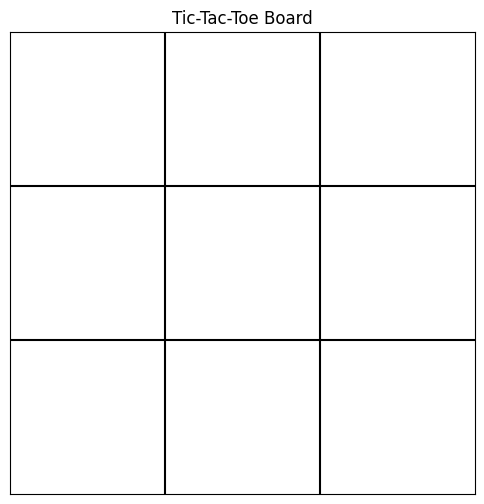

In [23]:
# training
rounds=1
p1 = RLPlayer("Alice")  # X
p2 = QwenPlayer("Qwen") # O

game = Board(p1, p2)
game.play(rounds)

#store the success policies of each agent
#p1.savePolicy()
#p2.savePolicy()



### Fix the data for nice visualization

In [24]:
game.scoreboard[p1.name]=game.scoreboard.pop('p1')
game.scoreboard[p2.name]=game.scoreboard.pop('p2')

In [25]:
print(game.scoreboard)

{'Alice': 1, 'Qwen': 0}


In [26]:
#print(p1.game_state)
#print(p2.game_state)

###  Define a function to create the DataFrame with alternating symbols

In [27]:
def create_dataframe(data):
    games = []

    for gstat in data:
        
        game_no = int(list(gstat.keys())[0]) 
        # Merge p1 and p2 moves based on alternating symbols

        p1_moves = gstat[game_no]['p1']
        p2_moves = gstat[game_no]['p2']
        
        for move in p1_moves:
          
            games.append({
                'game_no': game_no,
                'player': move['player'],
                'symbol': 1,  # Player 1 symbol is always 1
                'move_no':  move['move']['no'],
                'move_action': move['move']['action'],
                'move_value': move['move']['value'],
                'decision_type': move['move'].get('decision_type'),
                'boardHash': move['boardHash']
            })

        for move in p2_moves:
            games.append({
                'game_no': game_no,
                'player': move['player'],
                'symbol': -1,  # Player 2 symbol is always -1
                'move_no': move['move']['no'],
                'move_action': move['move']['action'],
                'move_value': move['move']['value'],
                'decision_type': move['move'].get('decision_type'),
                'boardHash': move['boardHash'] if "boardHash" in move else ""
            })
          
    return pd.DataFrame(games)

###  Generate the DataFrame

In [28]:
df = create_dataframe(game.statistics)

In [29]:
df_sorted = df.sort_values(by=['game_no', 'move_no', 'symbol'], ascending=[True, True, False])

# Reset the index if needed (optional)
df_sorted = df_sorted.reset_index(drop=True)

# Display the sorted DataFrame
df_sorted

,game_no,player,symbol,move_no,move_action,move_value,decision_type,boardHash
0,0,Alice,1,1,"(0, 0)",0,normal,None
1,0,Qwen,-1,1,"(1, 1)","I chose the center position (1, 1) because it ...",None,
2,0,Alice,1,2,"(2, 2)",0,normal,[ 1. 0. 0. 0. -1. 0. 0. 0. 1.]
3,0,Qwen,-1,2,"(2, 0)","Placing the mark at position (2, 0) blocks the...",None,
4,0,Alice,1,3,"(0, 2)",0,block,None
5,0,Qwen,-1,3,"(1, 0)","Placing my mark at (1,0) creates a threat on t...",None,
6,0,Alice,1,4,"(0, 1)",0,win,None
